## Paper Experiments

In [1]:
import benchmarks
import algorithm
import data
import importlib
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML, display
import tabulate

import warnings
warnings.filterwarnings('ignore')

In [2]:
def score(predicted, test):
    return np.mean((predicted-test)**2)

# 5.1 Lorenz’s chaotic model

# 5.2 The Eurozone and current account deficits

In [3]:
# import data 
X , Y = data.get_emu_data_numpy()
t_year = 19
X_train , Y_train = X[:t_year], Y[:t_year,np.newaxis]
X_test , Y_test = data.get_emu_data_numpy()

In [4]:
predictions_SC, w_SC = benchmarks.SC(X_train , Y_train, X_test)
score_SC = score(predictions_SC[:t_year], Y_test[:t_year])

In [5]:
predictions_KMM = benchmarks.KMM(X_train , Y_train, X_test)
score_KMM = score(predictions_KMM[:t_year], Y_test[:t_year])

In [6]:
predictions_elastic_net, _ = benchmarks.elastic_net(X_train , Y_train, X_test)
score_elastic_net = score(predictions_elastic_net[:t_year], Y_test[:t_year])

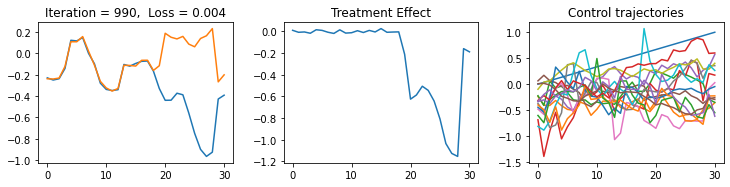

In [8]:
X, Y = data.get_emu_data()
train_X, train_y = X[:,:t_year,:], Y[:,:t_year,:]
test_X, test_y = data.get_emu_data()

model = algorithm.NeuralCDE(input_channels=train_X.shape[2], hidden_channels=5)

# l1_reg = 0.01
iterations = 1000

algorithm.train(model,train_X, train_y, test_X, test_y, iterations)

predictions_NC_SC = algorithm.predict(model,test_X).squeeze().numpy()
score_NC_SC = score(predictions_NC_SC[:t_year], Y_test[:t_year])

### Eurozone Counterfactual estimation performance.

In [10]:
headers = ["Method", "Score"]
results = [
    ["SC", score_SC],
    ["KMM", score_KMM],
    ["R-SC", score_elastic_net],
    ["NC-SC", score_NC_SC],
    
]
display(
    HTML(tabulate.tabulate(results, headers=headers, tablefmt="html"))
)


Method,Score
SC,0.0339767
KMM,0.032112
R-SC,0.0221702
NC-SC,0.000170962


# 5.3 Smoking control in California

In [11]:
# import data in correct format
t_year = 19
X , Y = data.get_smoking_data_numpy()
X_train , Y_train = X[:t_year], Y[:t_year,np.newaxis]
X_test , Y_test = X[:t_year], Y[:t_year,np.newaxis]

In [12]:
predictions_SC, w_SC = benchmarks.SC(X_train , Y_train, X_test)
score_SC_smoke = score(predictions_SC, Y_test)

In [13]:
predictions_KMM = benchmarks.KMM(X_train , Y_train, X_test)
score_KMM_smoke = score(predictions_KMM, Y_test)

In [14]:
predictions_elastic_net, _ = benchmarks.elastic_net(X_train , Y_train, X_test)
score_elastic_net_smoke = score(predictions_elastic_net, Y_test)

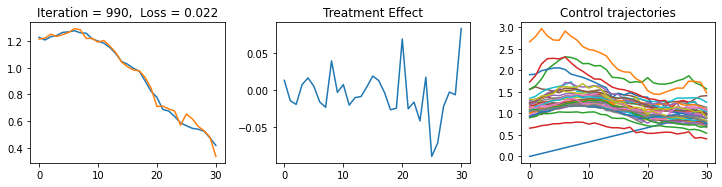

In [15]:
X, Y = data.get_smoking_data()
train_X, train_y = X[:,:t_year,:], Y[:,:t_year,:]
test_X, test_y = data.get_smoking_data()

model = algorithm.NeuralCDE(input_channels=train_X.shape[2], hidden_channels=5)

# l1_reg = 0.01
iterations = 1000

algorithm.train(model,train_X, train_y, test_X, test_y, iterations)

predictions_NC_SC = algorithm.predict(model,test_X).squeeze().numpy()
score_NC_SC_smoke = score(predictions_NC_SC[:t_year], Y_test[:t_year])

###  Smoking control Counterfactual estimation performance.

In [17]:
headers = ["Method", "Score"]
results = [
    ["SC", score_SC_smoke],
    ["KMM", score_KMM_smoke],
    ["R-SC", score_elastic_net_smoke],
    ["NC-SC", score_NC_SC_smoke],
    
]
display(
    HTML(tabulate.tabulate(results, headers=headers, tablefmt="html"))
)


Method,Score
SC,0.000274366
KMM,0.001482
R-SC,0.0256852
NC-SC,0.0256975
